## Referrence

https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/

https://github.com/ghallak/jpeg-python


In [48]:
!gdown --id 19kEQibPpJZZWe69ik_zYnQnxSFYsjMNX

Downloading...
From: https://drive.google.com/uc?id=19kEQibPpJZZWe69ik_zYnQnxSFYsjMNX
To: /content/compress.jpg
100% 9.04k/9.04k [00:00<00:00, 15.4MB/s]


In [49]:
import cv2
import math
import numpy as np
from scipy import fftpack
from PIL import Image
import matplotlib.pyplot as plt

## Utils

In [50]:
import numpy as np


def load_quantization_table(component):
    if component == 'lum':
        return np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        return np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])


def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result


def binstr_flip(binstr):
    # check if binstr is a binary string
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))


def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)


def flatten(lst):
    return [item for sublist in lst for item in sublist]

## Huffman

In [51]:
from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict

## Encoder

In [52]:

def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values


def write_to_file(filepath, dc, ac, blocks_count, tables):
    f = open(filepath, 'w')

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()

In [53]:
npmat = cv2.imread('compress.jpg')
print(npmat.shape)

rows, cols = npmat.shape[0], npmat.shape[1]

# block size: 8x8
blocks_count = rows // 8 * cols // 8
print(blocks_count, rows, cols)

# dc is the top-left cell of the block, ac are all the other cells
dc = np.empty((blocks_count, 3), dtype=np.int32)
ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

block_index = -1
for i in range(0, rows, 8):
    for j in range(0, cols, 8):
        # try:
        block_index += 1
        # except NameError:
        #     block_index = 0

        for k in range(3):
            # split 8x8 block and center the data range on zero
            # [0, 255] --> [-128, 127]
            block = npmat[i:i+8, j:j+8, k] - 128

            dct_matrix = dct_2d(block)
            quant_matrix = quantize(dct_matrix, 'lum' if k == 0 else 'chrom')
            zz = block_to_zigzag(quant_matrix)
            
            dc[block_index, k] = zz[0]
            ac[block_index, :, k] = zz[1:]

H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
H_AC_Y = HuffmanTree(
        flatten(run_length_encode(ac[i, :, 0])[0]
                for i in range(blocks_count)))
H_AC_C = HuffmanTree(
        flatten(run_length_encode(ac[i, :, j])[0]
                for i in range(blocks_count) for j in [1, 2]))

tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
            'ac_y': H_AC_Y.value_to_bitstring_table(),
            'dc_c': H_DC_C.value_to_bitstring_table(),
            'ac_c': H_AC_C.value_to_bitstring_table()}

write_to_file('compress.txt', dc, ac, blocks_count, tables)

(240, 240, 3)
900 240 240


## Decoder

In [54]:

class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')

In [55]:
dc, ac, tables, blocks_count = read_image_file('compress.txt')

# assuming that the block is a 8x8 square
block_side = 8

# assuming that the image height and width are equal
image_side = int((blocks_count) ** 0.5) * block_side

blocks_per_line = image_side // block_side

image = np.empty((image_side, image_side, 3), dtype=np.uint8)

for block_index in range(blocks_count):
    i = block_index // blocks_per_line * block_side
    j = block_index % blocks_per_line * block_side

    for c in range(3):
        zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
        quant_matrix = zigzag_to_block(zigzag)
        dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
        block = idct_2d(dct_matrix)
        image[i : i + 8, j : j + 8, c] = block + 128

image_after_compress = Image.fromarray(image, 'YCbCr')
image_after_compress = cv2.cvtColor(np.array(image_after_compress), cv2.COLOR_RGB2GRAY)

# Result

Text(0.5, 1.0, 'JPEG image')

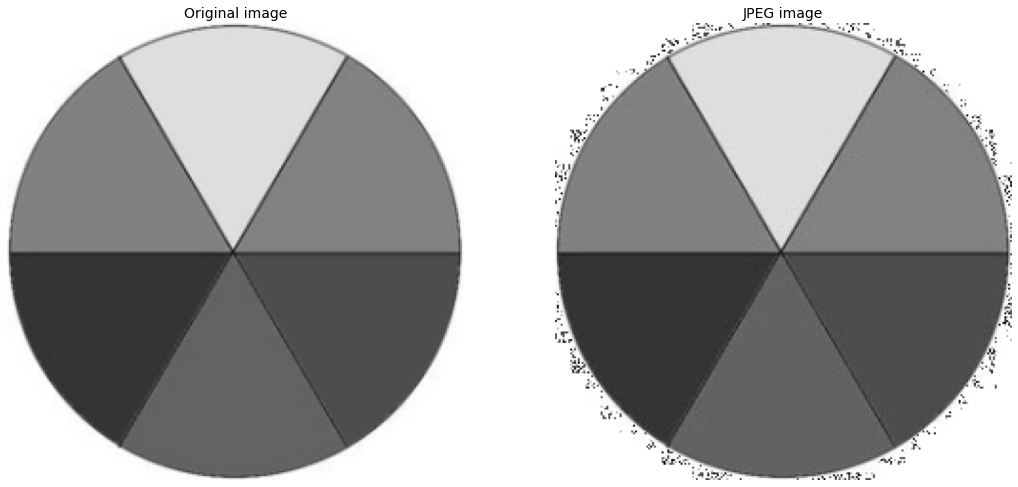

In [56]:
original = cv2.imread('compress.jpg')


fig, ax = plt.subplots(1, 2, figsize=(18, 18))
ax[0].imshow(original, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original image", fontsize=14)

ax[1].imshow(image_after_compress, cmap="gray")
ax[1].axis("off")
ax[1].set_title("JPEG image", fontsize=14)